<a href="https://colab.research.google.com/github/jm12312/CV-Projects/blob/main/GAN%20for%20Anime%20faces%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/splcher/animefacedataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: joshuamenezes
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:02<00:00, 142MB/s]

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn.functional as F

In [ ]:
img_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder("animefacedataset/", transform=T.Compose([
    T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [ ]:
def denormalise(img):
  return img * stats[1][0] + stats[0][0]

torch.Size([128, 3, 64, 64])


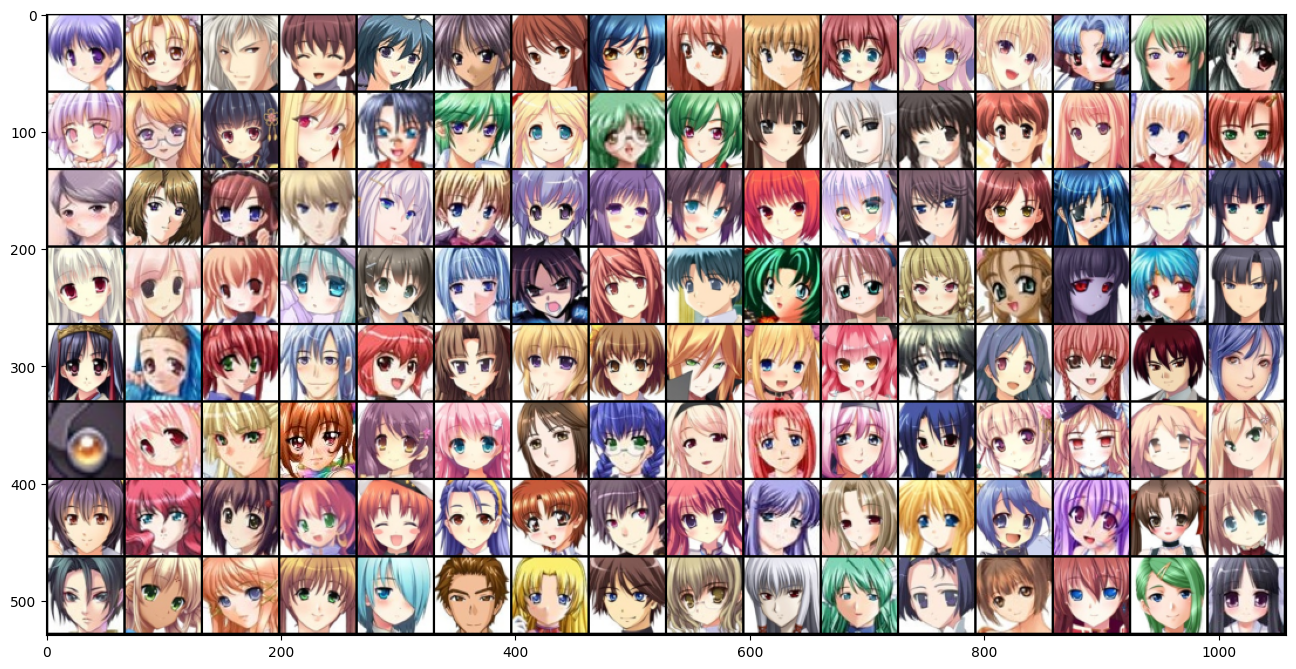

In [ ]:
for img, _ in train_dl:
  plt.figure(figsize=(16, 16))
  print(img.shape)
  plt.imshow(make_grid(denormalise(img), nrow=16).permute(1, 2, 0))
  break

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), #64, 32, 32
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), #128, 16, 16
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), #256, 8, 8
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), #512, 4, 4
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), #1, 1, 1
    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128 # more variety/features could be created

generator = nn.Sequential(
    # 128, 1, 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False), #512, 4, 4
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), #256, 8, 8
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), #128, 16, 16
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), #64, 32, 32
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False), #3, 64, 64
    nn.Tanh()
    # pixel range -1, 1
    # 3,64,64
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


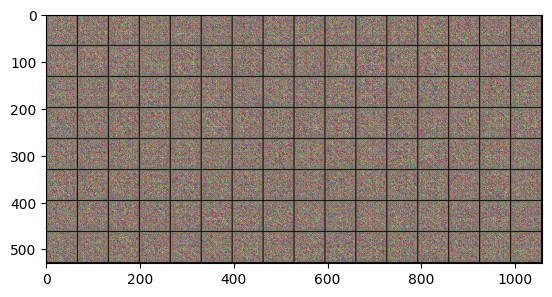

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
plt.imshow(make_grid(denormalise(fake_images), nrow=16).permute(1, 2, 0))

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score


In [ ]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  loss.backward()
  opt_g.step()
  return loss.item()

In [ ]:
from torchvision.utils import save_image
import os
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_images(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denormalise(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


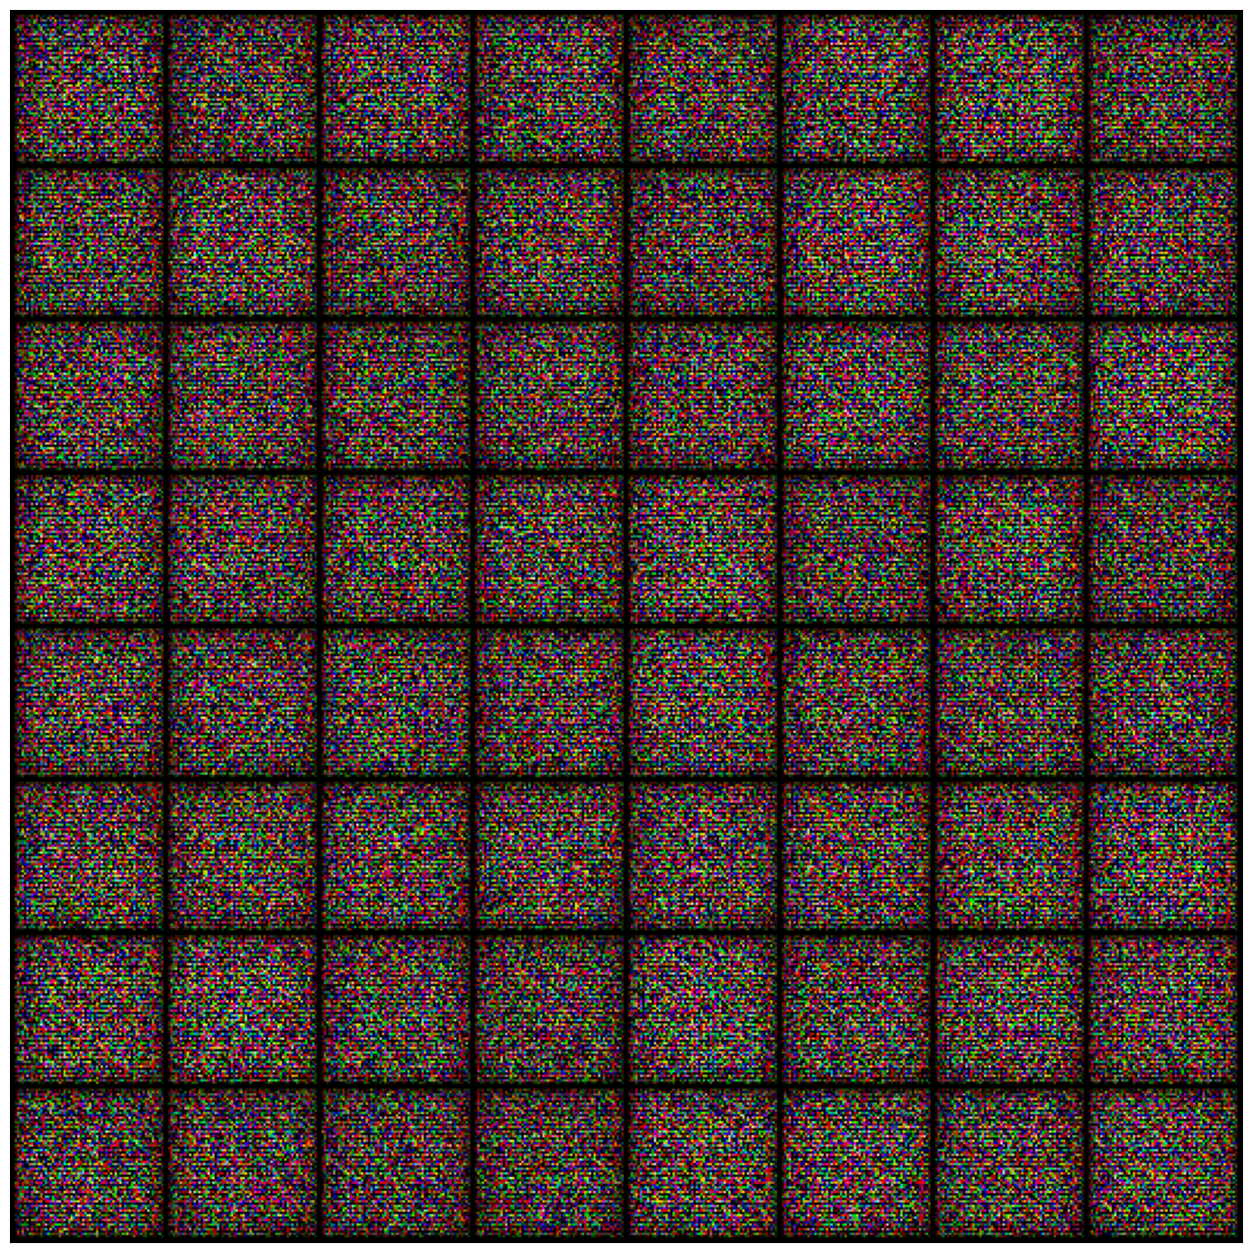

In [ ]:
save_images(0, fixed_latent)

In [ ]:
import tqdm

In [ ]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm.tqdm(train_dl):
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g = train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    save_images(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 10

In [ ]:
history = fit(epochs, lr)

100%|██████████| 497/497 [03:01<00:00,  2.73it/s]


Epoch [1/10], loss_g: 7.8414, loss_d: 0.7802, real_score: 0.9511, fake_score: 0.4642
Saving generated-images-0001.png


100%|██████████| 497/497 [03:00<00:00,  2.75it/s]


Epoch [2/10], loss_g: 8.0110, loss_d: 0.8784, real_score: 0.9668, fake_score: 0.5148
Saving generated-images-0002.png


100%|██████████| 497/497 [03:04<00:00,  2.69it/s]


Epoch [3/10], loss_g: 3.3839, loss_d: 0.1658, real_score: 0.8991, fake_score: 0.0392
Saving generated-images-0003.png


100%|██████████| 497/497 [02:59<00:00,  2.77it/s]


Epoch [4/10], loss_g: 9.4681, loss_d: 0.4559, real_score: 0.9599, fake_score: 0.3152
Saving generated-images-0004.png


100%|██████████| 497/497 [02:59<00:00,  2.77it/s]


Epoch [5/10], loss_g: 7.0130, loss_d: 0.1482, real_score: 0.9810, fake_score: 0.1102
Saving generated-images-0005.png


100%|██████████| 497/497 [02:59<00:00,  2.77it/s]


Epoch [6/10], loss_g: 10.0798, loss_d: 0.8079, real_score: 0.5571, fake_score: 0.0000
Saving generated-images-0006.png


100%|██████████| 497/497 [02:59<00:00,  2.78it/s]


Epoch [7/10], loss_g: 5.6395, loss_d: 0.1334, real_score: 0.9184, fake_score: 0.0166
Saving generated-images-0007.png


100%|██████████| 497/497 [02:59<00:00,  2.78it/s]


Epoch [8/10], loss_g: 5.4734, loss_d: 0.1323, real_score: 0.9405, fake_score: 0.0601
Saving generated-images-0008.png


100%|██████████| 497/497 [03:01<00:00,  2.74it/s]


Epoch [9/10], loss_g: 7.6712, loss_d: 0.0608, real_score: 0.9530, fake_score: 0.0062
Saving generated-images-0009.png


100%|██████████| 497/497 [03:00<00:00,  2.75it/s]

Epoch [10/10], loss_g: 5.2592, loss_d: 0.1543, real_score: 0.9246, fake_score: 0.0475
Saving generated-images-0010.png


In [ ]:
history += fit(5, lr, start_idx=26)

100%|██████████| 497/497 [02:59<00:00,  2.77it/s]


Epoch [1/5], loss_g: 5.8043, loss_d: 0.0930, real_score: 0.9566, fake_score: 0.0237
Saving generated-images-0026.png


100%|██████████| 497/497 [03:00<00:00,  2.75it/s]


Epoch [2/5], loss_g: 7.2130, loss_d: 0.0741, real_score: 0.9708, fake_score: 0.0381
Saving generated-images-0027.png


100%|██████████| 497/497 [02:59<00:00,  2.77it/s]


Epoch [3/5], loss_g: 11.4000, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0028.png


100%|██████████| 497/497 [03:00<00:00,  2.76it/s]


Epoch [4/5], loss_g: 9.4959, loss_d: 1.4162, real_score: 0.4592, fake_score: 0.0000
Saving generated-images-0029.png


100%|██████████| 497/497 [03:00<00:00,  2.76it/s]

Epoch [5/5], loss_g: 12.8553, loss_d: 0.0521, real_score: 0.9546, fake_score: 0.0003
Saving generated-images-0030.png


In [ ]:
import cv2

video_fname = 'generated-images.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(video_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

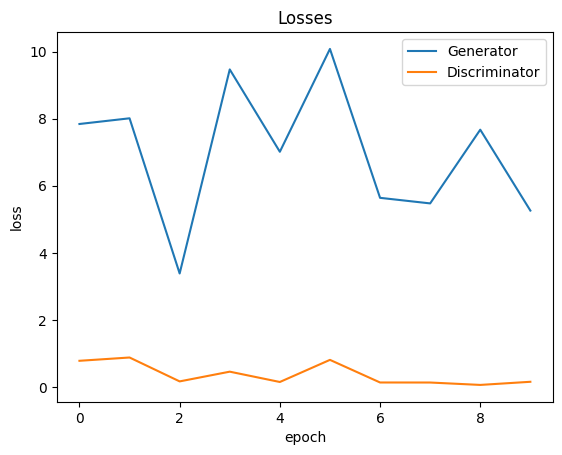

In [ ]:
plt.plot(history[0], '-')
plt.plot(history[1], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Generator', 'Discriminator'])
plt.title('Losses');